In [ ]:
!git clone https://github.com/maxme1/sudoku

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

from sudoku.sudoku import solve, print_field

In [2]:
def GetSudokuField(colour_image, width_square):
    #############################################
    #
    # Function get colour image from cv2.imread()
    # return colour image of sudoku field
    # format same with input
    #
    # width_square is a size fot output image
    #
    #############################################
    
    # convert to gray scale
    gray_image = cv2.cvtColor(colour_image, cv2.COLOR_BGR2GRAY)
    
    # get binary image fot contour calculate
    min_value = np.min(gray_image)
    max_value = np.max(gray_image)
    treshhold_value = min_value + (max_value - min_value)/4
    binary_image = (gray_image < treshhold_value).astype(np.uint8)
    
    # get the max contour is a square of sudoku field
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_contour = max(contours, key=cv2.contourArea)
    
    # approximate max contour to get approximate square
    epsilon = 0.02 * cv2.arcLength(max_contour, True)
    max_contour = cv2.approxPolyDP(max_contour, epsilon, True)
    
    # get homography matrix
    square = np.array([[0, 0], [0, width_square], [width_square, width_square], [width_square, 0]], dtype=np.float32)
    H, _ = cv2.findHomography(max_contour, square)
    
    # get output image
    sudoku_field = cv2.warpPerspective(colour_image, H, (width_square, width_square))
    
    return sudoku_field, H

In [3]:
def GetValue(cell):
    #
    # Crosscorrelation method
    # Function get cell image and return predicted label
    #
    
    # Reshape cell for matching
    dx = 20
    w = cell.shape[0]
    dw = int(w/10)
    cell = cell[dw:w-dw,dw:w-dw]
    cell = cv2.resize(cell, (dx, dx), interpolation=cv2.INTER_AREA)
    if(np.max(cell)<=1):
         cell *= 255
    
    # add blur
    cell = cv2.GaussianBlur(cell, (7,7), 1)
    
    if(np.mean(cell) <= 10):
        return '?'
    
    # Comapre with templates
    values = np.zeros(9)
    for name in range(1,10):
        path = 'template/'+str(name)+'.jpg'
        template = cv2.imread(path)
        template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
        template = cv2.resize(template, (dx, dx), interpolation=cv2.INTER_AREA)
        #add blur
        template = cv2.GaussianBlur(template, (7,7), 1)

        result = cv2.matchTemplate(cell, template, cv2.TM_CCOEFF_NORMED)

        _, max_val, _, _ = cv2.minMaxLoc(result)
        values[name-1] = max_val
    
    ind_max = np.argmax(values) + 1
    
    return ind_max

In [4]:
def GetSudokuBoard(sudoku_field,width_field):
    #
    # Get matrix with numbers
    #
    
    sudoku_board = ['?']*9
    sudoku_board = [sudoku_board]*9
    sudoku_board = np.array(sudoku_board)


    gray_sudoku_field = cv2.cvtColor(sudoku_field, cv2.COLOR_BGR2GRAY)
    min_value = np.min(gray_sudoku_field)
    max_value = np.max(gray_sudoku_field)
    treshhold_value = min_value + (max_value - min_value)/5
    binary_sudoku_field = (gray_sudoku_field < treshhold_value).astype(np.uint8)

    h = width_field/9
    for i in range(9):
        for j in range(9):
            cell = binary_sudoku_field[int(h*i):int(h*(i+1)),int(h*j):int(h*(j+1))]
            sudoku_board[i][j] = GetValue(cell)
    
    return sudoku_board

In [5]:
def SolveSudoku(sudoku_field,width_field):
    
    sudoku_board = GetSudokuBoard(sudoku_field,width_field)
    
    # Make valid format of field for sudoku solver
    puzzle = ''
    for i in range(9):
        for j in range(9):
            puzzle += str(sudoku_board[i][j])+' '
    
    # solve sudoku
    solution = next(solve(puzzle))
    
    h = width_field/9
    # draw solution on image
    for i in range(9):
        for j in range(9):
            if(sudoku_board[i][j] == '?'):
                template = cv2.imread('template/'+str(solution[i,j])+'.jpg')
                template = cv2.resize(template, (int(h), int(h)), interpolation=cv2.INTER_AREA)
                number = template / 5

                sudoku_field[int(h*i):int(h*(i+1)),int(h*j):int(h*(j+1))] -= number.astype(np.uint8)
    
    return sudoku_field

In [19]:
# read image and get sudoku field
image = cv2.imread('train_2.jpg')

image_0 = image[1600:,:]
image_1 = image[:2000,:]

# we can get only one field of sudoku, if image contain 2 fields, please separate them
width_field = 900
sudoku_field_0, H0 = GetSudokuField(image_0,width_field)
sudoku_field_1, H1 = GetSudokuField(image_1,width_field)

In [7]:
sudoku_solve_0 = SolveSudoku(sudoku_field_0,width_field)
sudoku_solve_1 = SolveSudoku(sudoku_field_1,width_field)

True

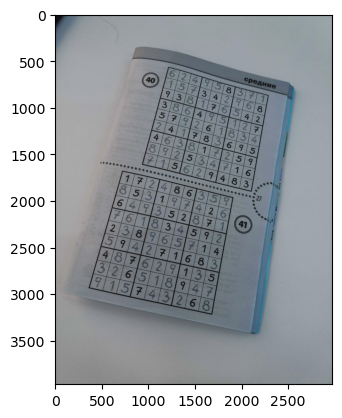

In [8]:
(h,w,_) = image_0.shape
solve_0 = cv2.warpPerspective(sudoku_solve_0, np.linalg.inv(H0), (w, h))
(h,w,_) = image_1.shape
solve_1 = cv2.warpPerspective(sudoku_solve_1, np.linalg.inv(H1), (w, h))

mask0 = (cv2.cvtColor(solve_0, cv2.COLOR_BGR2GRAY) > 0).astype(np.uint8)
mask1 = (cv2.cvtColor(solve_1, cv2.COLOR_BGR2GRAY) > 0).astype(np.uint8)

image_solve = image.copy()

image_solve[1600:,:] = cv2.bitwise_and(image_solve[1600:,:],image_0,mask=(1-mask0))
image_solve[:2000,:] = cv2.bitwise_and(image_solve[:2000,:],image_1,mask=(1-mask1))

image_solve[1600:,:] = cv2.add(image_solve[1600:,:],solve_0)
image_solve[:2000,:] = cv2.add(image_solve[:2000,:],solve_1)

plt.imshow(image_solve)
cv2.imwrite('sudoku_solve.jpg',image_solve)